In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

/ssd_scratch/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
casestore = {}

db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [
    dict(name="base", id="x6a1c-neutral_boundary_dev", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),

]


for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                            double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                            unnormalise_geom = case["unnormalise_geom"])

CHECK: Total domain volume is 1.607E+00 [m3]


# PFR

/ssd_scratch/anaconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  func(*args, **kwargs)


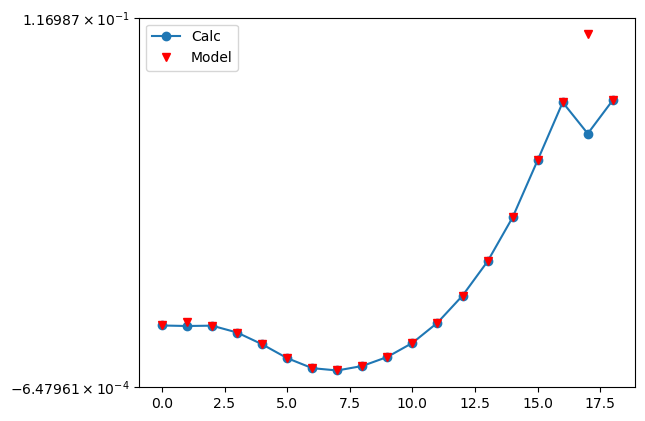

In [7]:
ds_orig = casestore["base"].ds.copy()
ds = ds_orig.hermesm.select_region("lower_pfr")
# ds = ds_orig.copy()

m = ds.metadata

calc = []
model = []

cell = ds.isel(x=2)
guard = ds.isel(x=1)
def wall(param):
    return (cell[param].values + guard[param].values)/2

## EVERYTHING NORMALISED
Td = wall("Td") / m["Tnorm"]
Nd = wall("Nd") / m["Nnorm"]
dy = wall("dy")
dl = wall("dl") / m["rho_s0"]
dz = wall("dz") 
g22 = wall("g22") / (1/(m["rho_s0"] * m["rho_s0"]))
g_33 = wall("g_33") / (m["rho_s0"]**2)
dtor = wall("dz") * np.sqrt(g_33) 
dv = cell["dv"] / (m["rho_s0"]**3)

q_e = 1
Mi = 2

vth = np.sqrt( (q_e * Td) / Mi)

energy_refl_factor = 0.75
fast_refl_fraction = 0.8
gamma = 1 - energy_refl_factor * fast_refl_fraction - (1-fast_refl_fraction)*((3/m["Tnorm"])/(2*Td))

q = gamma * Nd * q_e * Td * vth  # Wm-2
da = dl * dtor
flux = q * da  # W
power = flux / dv


calc =  power

norm = constants("q_e") * m["Nnorm"] * m["Tnorm"] * m["Omega_ci"]
model = (cell["Ed_wall_refl"]/norm).squeeze().values * -1

fig, ax = plt.subplots()
ax.plot(calc, marker = "o", label = "Calc")
ax.plot(model, lw = 0, marker = "v", label = "Model", c = "r")
ax.legend()
ax.set_yscale("symlog")

In [6]:
gamma

array([ -5.18216853,  -5.60582056,  -5.27122879,  -5.18216853,
        -4.95120135,  -4.60898786,  -4.29044037,  -4.1760761 ,
        -4.30256432,  -4.65624868,  -5.25183751,  -6.07468632,
        -7.11454908,  -8.33544485,  -9.5917112 , -10.59335525,
       -11.25634352, -13.83413273, -10.59335525])

/ssd_scratch/anaconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  func(*args, **kwargs)


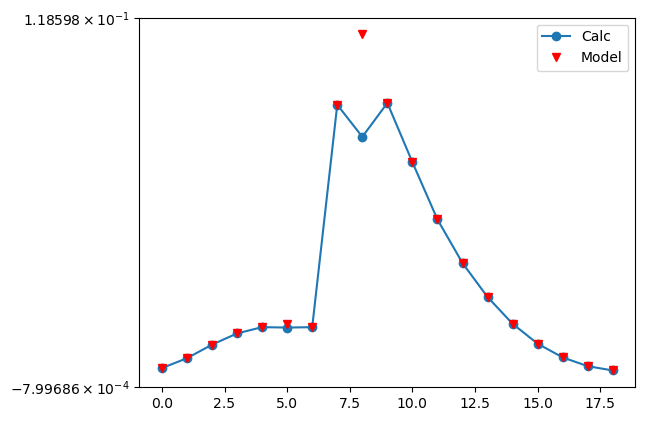

In [8]:
ds_orig = casestore["base"].ds.copy()
ds = ds_orig.hermesm.select_region("upper_pfr")
# ds = ds_orig.copy()

m = ds.metadata

calc = []
model = []

cell = ds.isel(x=2)
guard = ds.isel(x=1)
def wall(param):
    return (cell[param].values + guard[param].values)/2

## EVERYTHING NORMALISED
Td = wall("Td") / m["Tnorm"]
Nd = wall("Nd") / m["Nnorm"]
dy = wall("dy")
dl = wall("dl") / m["rho_s0"]
dz = wall("dz") 
g22 = wall("g22") / (1/(m["rho_s0"] * m["rho_s0"]))
g_33 = wall("g_33") / (m["rho_s0"]**2)
dtor = wall("dz") * np.sqrt(g_33) 
dv = cell["dv"] / (m["rho_s0"]**3)

q_e = 1
Mi = 2

vth = np.sqrt( (q_e * Td) / Mi)

energy_refl_factor = 0.75
fast_refl_fraction = 0.8
gamma = 1 - energy_refl_factor * fast_refl_fraction - (1-fast_refl_fraction)*((3/m["Tnorm"])/(2*Td))

q = gamma * Nd * q_e * Td * vth  # Wm-2
da = dl * dtor
flux = q * da  # W
power = flux / dv


calc =  power

norm = constants("q_e") * m["Nnorm"] * m["Tnorm"] * m["Omega_ci"]
model = (cell["Ed_wall_refl"]/norm).squeeze().values * -1

fig, ax = plt.subplots()
ax.plot(calc, marker = "o", label = "Calc")
ax.plot(model, lw = 0, marker = "v", label = "Model", c = "r")
ax.legend()
ax.set_yscale("symlog")

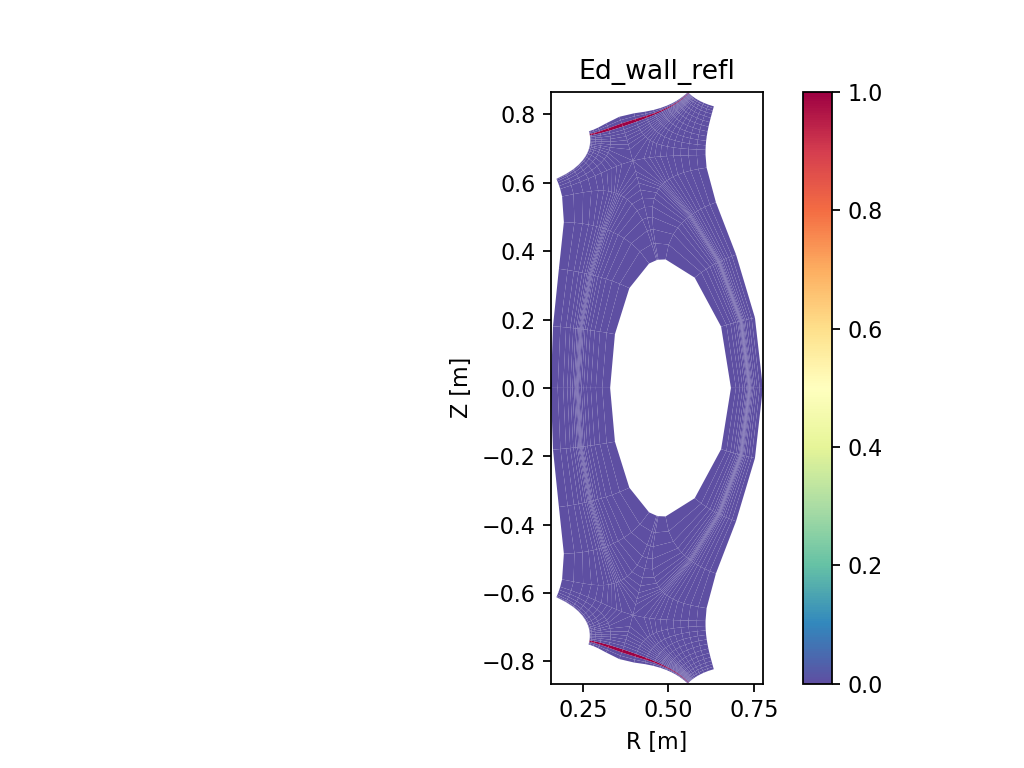

In [ ]:
%matplotlib widget
plt.close("all")

ds = casestore["base"].ds
m = ds.metadata
norm = constants("q_e") * m["Nnorm"] * m["Tnorm"] * m["Omega_ci"]


fig, ax = plt.subplots(dpi = 160)
(ds["Ed_wall_refl"]/norm*-1).bout.polygon(ax = ax, cmap = "Spectral_r", linewidth = 0, antialias = True)


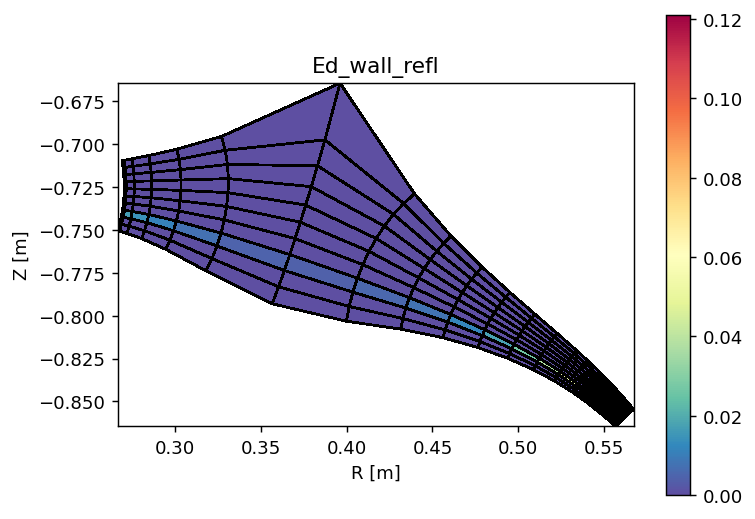

In [6]:
fig, ax = plt.subplots(dpi = 130)

(ds["Ed_wall_refl"]/norm*-1).bout.polygon(cmap = "Spectral_r", ax = ax, linewidth = 1)


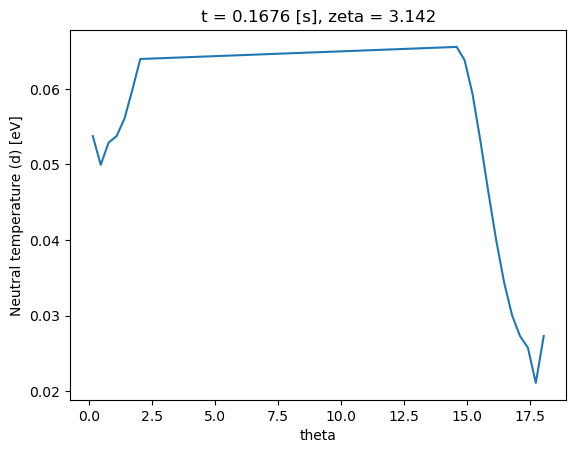

In [13]:
(0.5*(cell["Td"]+guard["Td"]) / m["Tnorm"]).plot()

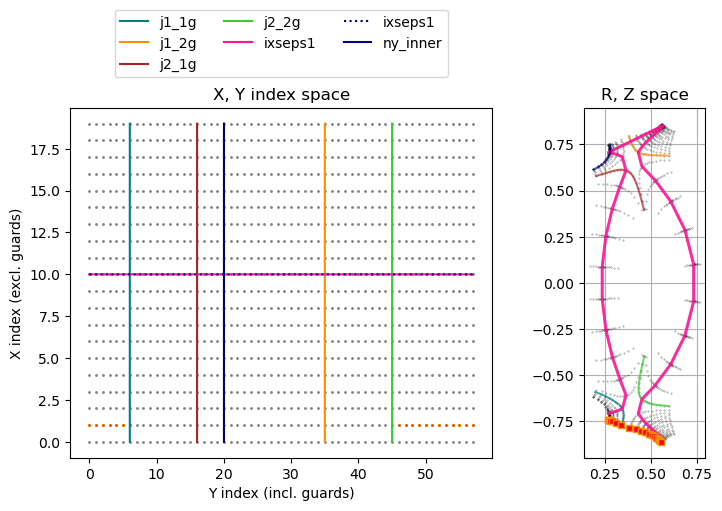

In [8]:
plot_selection(ds_orig, guard)

In [5]:
q

array([0.06681873, 0.06738276, 0.069342  , 0.06681873, 0.05966291,
       0.04961039, 0.0409891 , 0.03704221, 0.03799715, 0.04201254,
       0.04893507, 0.05857521, 0.07101866, 0.08696467, 0.10795993,
       0.13506349, 0.15883108, 0.14373124, 0.13506349])

# SOL

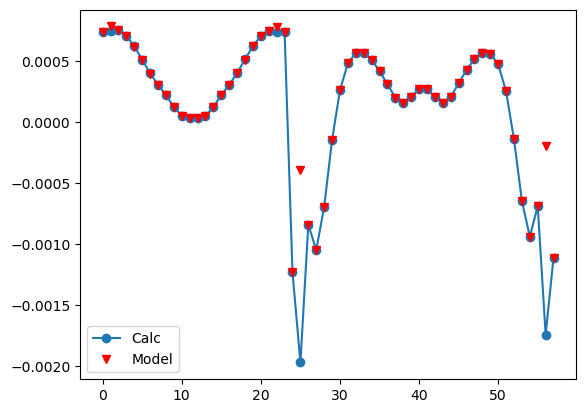

In [9]:
ds = casestore["base"].ds
# ds = ds_orig.copy()

m = ds.metadata

calc = []
model = []

cell = ds.isel(x=-3)
guard = ds.isel(x=-2)
def wall(param):
    return (cell[param].values + guard[param].values)/2

## EVERYTHING NORMALISED
Td = wall("Td") / m["Tnorm"]
Nd = wall("Nd") / m["Nnorm"]
dy = wall("dy")
dl = wall("dl") / m["rho_s0"]
dz = wall("dz") 
g22 = wall("g22") / (1/(m["rho_s0"] * m["rho_s0"]))
g_33 = wall("g_33") / (m["rho_s0"]**2)
dtor = wall("dz") * np.sqrt(g_33) 
dv = cell["dv"] / (m["rho_s0"]**3)

q_e = 1
Mi = 2

vth = np.sqrt( (q_e * Td) / Mi)

energy_refl_factor = 0.75
fast_refl_fraction = 0.8
gamma = 1 - energy_refl_factor * fast_refl_fraction - (1-fast_refl_fraction)*((3/m["Tnorm"])/(2*Td))

q = gamma * Nd * q_e * Td * vth  # Wm-2
da = dl * dtor
flux = q * da  # W
power = flux / dv


calc = power

norm = constants("q_e") * m["Nnorm"] * m["Tnorm"] * m["Omega_ci"]
model = (cell["Ed_wall_refl"]/norm).squeeze().values * -1

fig, ax = plt.subplots()
ax.plot(calc, marker = "o", label = "Calc")
ax.plot(model, lw = 0, marker = "v", label = "Model", c = "r")
ax.legend()
# ax.set_yscale("symlog")

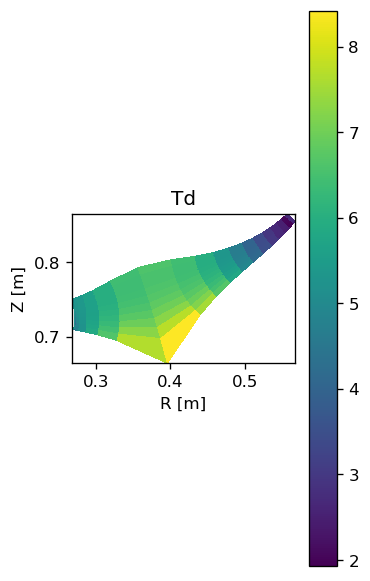

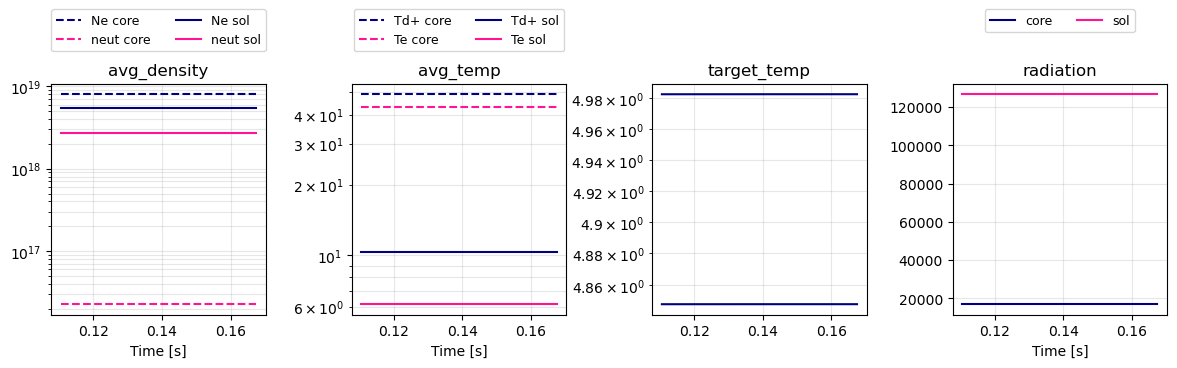

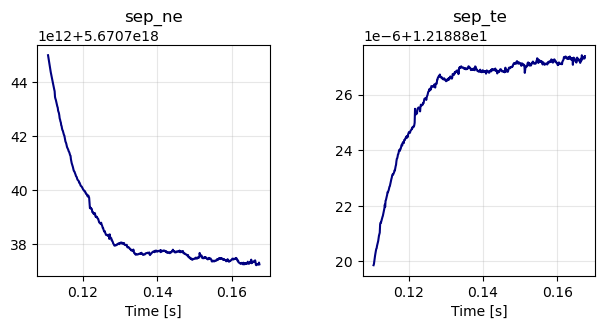

In [6]:
Monitor(casestore["base"], [["avg_density", "avg_temp", "target_temp","radiation"], ["sep_ne", "sep_te"]])